# BMEB W4020: Circuits in the Brain 2025 Fall Project \#2

*Author:* Shashwat Shukla <shashwat.shukla@columbia.edu>

Based on past work by Tingkai Liu and Cong Han

*Copyright 2025* Bionet Lab

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All). 
Make sure you fill up your name and collaborators below:

### Your names and UNI here

In this project, you will encode, decode and identify a biophysical neuron consisting of a dendritic tree, a soma, and a conductance-based axon hillock. The axon hillock is modelled as ON-OFF neurons in AER configuration.
<center><img src="figures/fig1.png" width=600 ></center>
<center><b>Figure 1</b>: Neuron modeled as [Filter]-[Encoder] Cascade.</center>

<center><img src="figures/fig2.png" width=600 ></center>
<center><b>Figure 2</b>: Dendritic processing: Two linear filters. Soma: ON-OFF encoder in AER configuration.</center>

## Problem 1

In this part, you will encode and decode a randomly generated input stimulus using the given neuron model when the dendritic filter is known to you. In particular, the dendritic filter is defined as $h_1(t) = 300 \cdot e^{-300\cdot t}$ and $h_2(t) = 200 \cdot e^{-200\cdot t}$. We further let $u_1 = u_2 = u$.

### Questions: 

1. (20 points) Encode a randomly generated signal $u(t)$ of bandwidth $50$ Hertz using the given neuron model, and plot the time-course of the membrane voltage of the soma. Also detect and label the spikes from the ON and OFF channels on the same plot.
2. (20 points) Use the detected spikes to decode the input signal $u(t)$. Plot the time-courses of the decoded and original input signal on the same plot to illustrate the quality of recovery. Also plot the time-course of the corresponding SNR between the signals.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def signal_generator(t, samples, sample_times, omega):
    signal = np.zeros_like(t)
    for s, st in zip(samples, sample_times):
        signal += omega / np.pi * s * np.sinc(omega / np.pi * (t - st))
    return signal

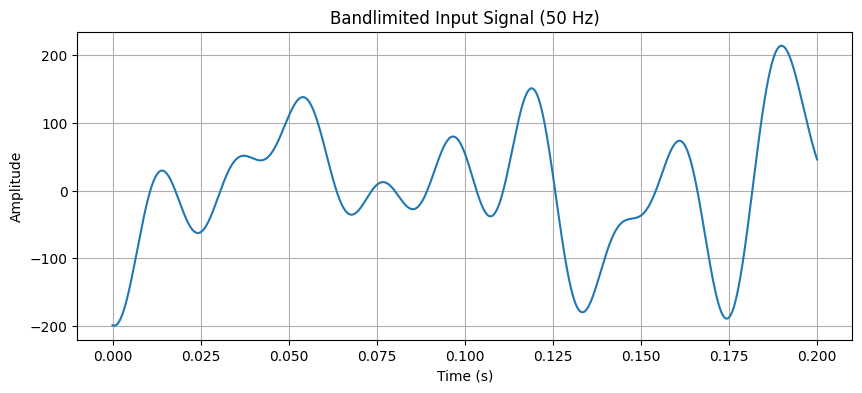

In [3]:
# Generate the input signal to the dendrite
f = 50  # Hertz
omega = 2 * np.pi * f
T = 2 * np.pi / omega
omega_pi = omega / np.pi
dt = 1e-6  # timestep (sec)
t = np.arange(0, 0.2, dt)

### Your answer here ###
# Generate sample times (at or above Nyquist rate)
num_samples = int(np.ceil(t[-1] * f * 2)) + 1  # at least 2*f samples per second
sample_times = np.linspace(0, t[-1], num_samples)

# Generate random samples
samples = np.random.randn(num_samples)

# Generate the bandlimited input signal
u = signal_generator(t, samples, sample_times, omega)
# u = u / np.max(np.abs(u))  # normalize to [-1, 1]

# Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(t, u)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Bandlimited Input Signal (50 Hz)')
plt.grid(True)
plt.show()

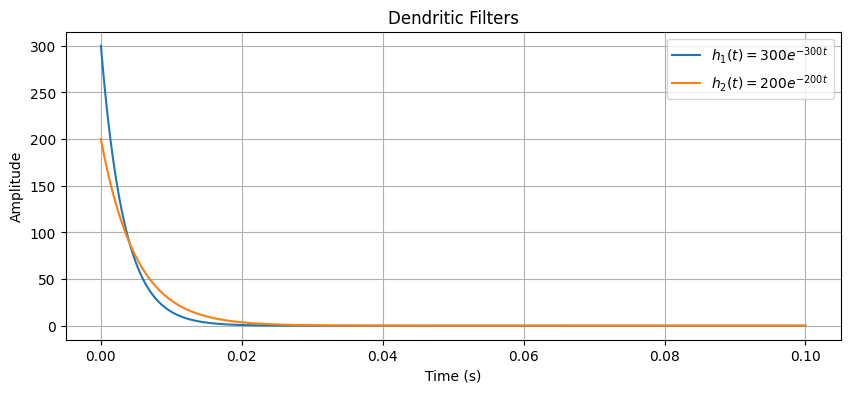

In [4]:
# Generate the dendritic filters
t_filt = np.arange(0, 0.1, dt)

### Your answer here ###
# Define the dendritic filters as exponential decay functions
h1 = 300 * np.exp(-300 * t_filt)
h2 = 200 * np.exp(-200 * t_filt)

# Plot the filters
plt.figure(figsize=(10, 4))
plt.plot(t_filt, h1, label='$h_1(t) = 300 e^{-300t}$')
plt.plot(t_filt, h2, label='$h_2(t) = 200 e^{-200t}$')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Dendritic Filters')
plt.legend()
plt.grid(True)
plt.show()

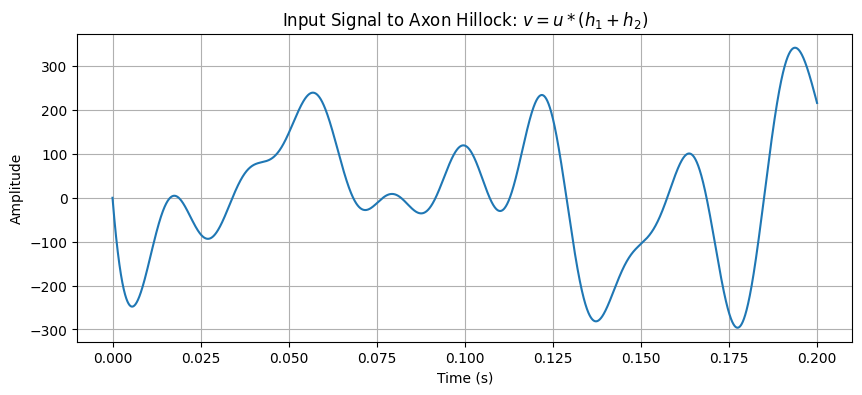

In [5]:
# Compute the input signal to the axon hillock
### Your answer here ###
# v = u * (h1 + h2) - convolution of input with sum of dendritic filters
v = np.convolve(u, h1 + h2, mode='full')[:len(t)] * dt

# Plot the filtered signal
plt.figure(figsize=(10, 4))
plt.plot(t, v)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input Signal to Axon Hillock: $v = u * (h_1 + h_2)$')
plt.grid(True)
plt.show()

In [ ]:
# Encode the input signal
delta = 0.2
### Your answer here ###
def tem_encode(u, t, params):
    """
    ASDM encoding with ON-OFF neurons in AER configuration.
    Both integrators reset when either one crosses its threshold.
    """

    delta = params["delta"]
    kappa = params["kappa"]
    b = params.get("b", 0)  # bias term, default 0

    dt = t[1] - t[0]  # assume uniform sampling
    
    # Initialize
    tk_idx_1 = []  # ON neuron spike indices
    tk_idx_2 = []  # OFF neuron spike indices
    integ_traj_1 = []

    
    # Split signal into ON (positive) and OFF (negative) components
    u_on = np.clip(u, 0, None)  # positive part
    u_off = np.clip(u, None, 0)  # negative part (made positive)
    
    integrator = 0  # ON integrator


    for i in range(len(t)):
        # Integrate ON channel (positive signal)
        integrator += (u_on[i] + u_off[i]) * dt / kappa
        
        # Integrate OFF channel (negative signal made positive)
        
        
        # Check if ON neuron fires (crosses +delta)
        if integrator >= delta:
            tk_idx_1.append(i)
            # AER: both integrators reset
            integrator = 0

        
        # Check if OFF neuron fires (crosses +delta)
        elif integrator <= -delta:
            tk_idx_2.append(i)
            # AER: both integrators reset
            integrator = 0

        integ_traj_1.append(integrator)

    tk_1 = t[tk_idx_1]  # ON spike times
    tk_2 = t[tk_idx_2]  # OFF spike times
    return tk_1, tk_2, tk_idx_1, tk_idx_2, np.array(integ_traj_1)

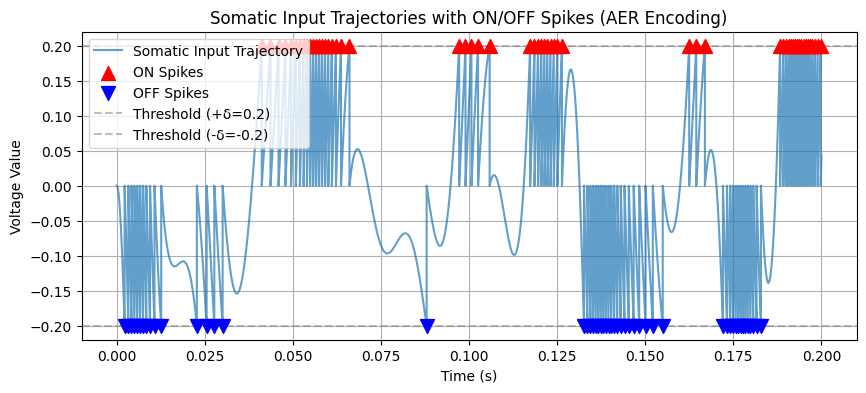

Number of ON spikes: 56
Number of OFF spikes: 51
Total spikes: 107


In [7]:
# Compute padded signals
### Your answer here ###
params = {"delta": delta, "kappa": 1, "b": 1}
tk_1, tk_2, tk_idx_1, tk_idx_2, integ_traj = tem_encode(v, t, params)

# Plot integrator trajectories with ON and OFF spikes
plt.figure(figsize=(10, 4))
plt.plot(t, integ_traj, label='Somatic Input Trajectory', alpha=0.7)

# Mark ON spikes (red triangles pointing up) at +delta
plt.scatter(tk_1, np.ones(len(tk_1)) * delta, color='red', marker='^', s=100, label='ON Spikes', zorder=5)

# Mark OFF spikes (blue triangles pointing down) at -delta
plt.scatter(tk_2, -np.ones(len(tk_2)) * delta, color='blue', marker='v', s=100, label='OFF Spikes', zorder=5)

# Add threshold lines
plt.axhline(y=delta, color='gray', linestyle='--', alpha=0.5, label=f'Threshold (+δ={delta})')
plt.axhline(y=-delta, color='gray', linestyle='--', alpha=0.5, label=f'Threshold (-δ={-delta})')

plt.xlabel('Time (s)')
plt.ylabel('Voltage Value')
plt.title('Somatic Input Trajectories with ON/OFF Spikes (AER Encoding)')
plt.legend()
plt.grid(True)
plt.show()
print(f'Number of ON spikes: {len(tk_1)}')
print(f'Number of OFF spikes: {len(tk_2)}')
print(f'Total spikes: {len(tk_1) + len(tk_2)}')

In [8]:
from compneuro.utils.signal import spike_detect, convolve
from scipy.integrate import cumulative_trapezoid as cumtrapz

In [ ]:
# Estimate G matrix
### Your answer here ###
def sinc_basis(t, sk, omega):
    if np.isscalar(sk):
        return omega / np.pi * np.sinc(omega / np.pi * (t - sk))
    return omega / np.pi * np.sinc(omega / np.pi * (t[None, :] - sk[:, None])) 

def compute_G(t, tk):
    N = len(tk) - 1
    t_long = np.arange(-1.25, 1.25, dt)  # time course of long signals
    h_long = np.zeros_like(t_long)
    start_idx = np.argmin(np.abs(t_long - np.min(t_filt)))
    h = h1 + h2
    stop_idx = start_idx + len(h)
    h_long[start_idx:stop_idx] = h  # padded filter
    g_long = np.sinc(t_long / np.pi * omega) / np.pi * omega  # padded zero-centered sinc

    # h*g
    t_hg_ll, hg_long = convolve(h_long, g_long, t_u=t_long, t_h=t_long, mode="same")
    s = np.array([(tk[k] + tk[k+1]) / 2 for k in range(N)])
    G = np.zeros((N, N))
    csum = cumtrapz(hg_long, dx=dt, initial=0.0)
    for k in range(N):
        G[:, k] = np.diff(csum[np.round((tk - s[k] - np.min(t_long)) / dt).astype(int)])
    return G


def compute_q(t, tk, u_org):
    N = len(tk) - 1
    q = np.zeros(N)
    for i in range(N):
        # Compute the integral of the sinc function over the interval [tk[i], tk[i+1]]
        q[i] = np.trapezoid(u_org[(t >= tk[i]) & (t <= tk[i+1])], t[(t >= tk[i]) & (t <= tk[i+1])])
    return q

def full_G(t, tk_1, tk_2):
    G1 = compute_G(t, tk_1)
    G2 = compute_G(t, tk_2)
    l1, b1 = G1.shape
    l2, b2 = G2.shape
    G_complete = [[G1, np.zeros((l1, b2))],
                    [np.zeros((l2, b1)), G2]]

    return np.block(G_complete)

def full_q(t, tk_1, tk_2, tem_params, u_org):
    """Compute full q vector for both neurons.
    Returns (N1-1) + (N2-1) values to match the G matrix structure."""
    kappa = tem_params["kappa"]
    delta = tem_params["delta"]

    # N1-1 values for ON channel, N2-1 values for OFF channel
    q1 = kappa * delta * np.ones(len(tk_1) - 1)
    q2 = -kappa * delta * np.ones(len(tk_2) - 1)
    
    # Concatenate to match block-diagonal G structure
    q = np.concatenate([q1, q2])

    return q



def aer_decode(t, tk1, tk2, tem_params, u_org):
    q = full_q(t, tk1, tk2, tem_params, u_org)
    G = full_G(t, tk1, tk2)
    
    # TODO: implement the delta-sensitive case
    # aka, the noramal c= G^inv q
    # Please use np.linalg.pinv(G, rcond=rcond) to get G inverse
    G_inv = np.linalg.pinv(G, rcond=1e-5)
    
    # get c vector through matric operation '@'
    # example, x = y @ z 
    c = G_inv @ q
    
    # get u from c using @ sinc_basis(t, sk, omega), find sk yourself
    c1, c2 = np.split(c, [len(tk_1)-1])
    
    sk_1 = np.array([(tk_1[k] + tk_1[k+1]) / 2 for k in range(len(tk_1)-1)])
    sk_2 = np.array([(tk_2[k] + tk_2[k+1]) / 2 for k in range(len(tk_2)-1)])
    u = c1 @ sinc_basis(t, sk_1, tem_params["omega"]) + c2 @ sinc_basis(t, sk_2, tem_params["omega"])
    u = u / np.max(np.abs(u))
    return  c, u

In [ ]:
params = {"delta": delta, "kappa": 1, "b": 1, "omega": omega}
c, u_rec = aer_decode(t, tk_1, tk_2, params, v)

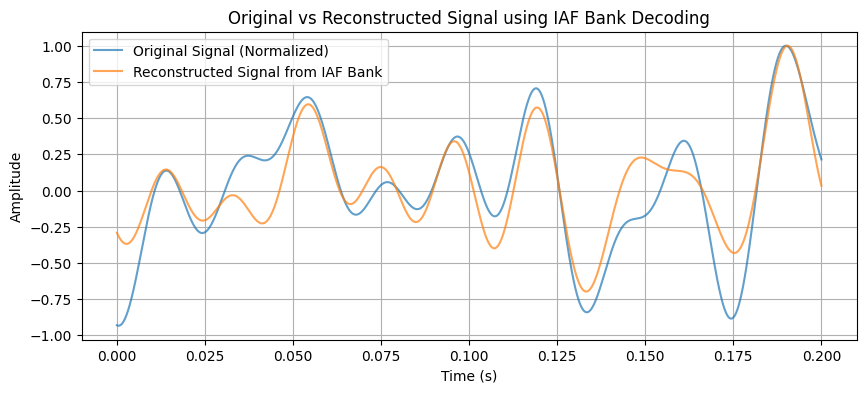

In [36]:
# Plot the original and reconstructed signals
plt.figure(figsize=(10, 4))
plt.plot(t, u / np.max(np.abs(u)), label='Original Signal (Normalized)', alpha=0.7)
plt.plot(t, u_rec / np.max(np.abs(u_rec)), label='Reconstructed Signal from IAF Bank', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Signal using IAF Bank Decoding')
plt.legend()
plt.grid(True)
plt.show()

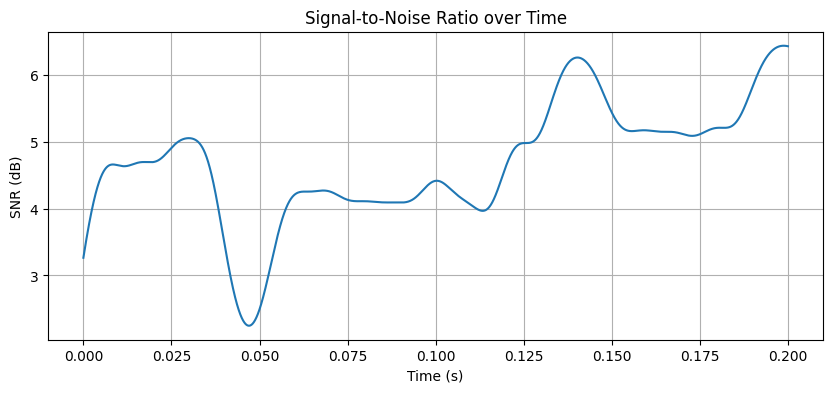

Final SNR: 6.43 dB


In [38]:
# Plot the original and reconstructed signals
u_norm = u / np.max(np.abs(u))
u_rec_norm = u_rec / np.max(np.abs(u_rec))

# Compute and plot SNR over time
def compute_snr(signal, error):
    """Compute SNR in dB using cumulative energy."""
    signal_energy = np.cumsum(signal**2)
    error_energy = np.cumsum(error**2)
    # Avoid division by zero
    snr = np.zeros_like(signal)
    valid = error_energy > 1e-10
    snr[valid] = 10 * np.log10(signal_energy[valid] / error_energy[valid])
    return snr

error = u_norm - u_rec_norm
snr = compute_snr(u_norm, error)

plt.figure(figsize=(10, 4))
plt.plot(t, snr)
plt.xlabel('Time (s)')
plt.ylabel('SNR (dB)')
plt.title('Signal-to-Noise Ratio over Time')
plt.grid(True)
plt.show()

# Print final SNR
final_snr = 10 * np.log10(np.sum(u_norm**2) / np.sum(error**2))
print(f'Final SNR: {final_snr:.2f} dB')

## Problem 2

You are each given a black-box instance of the neuron described above (with name `neuron_uni.py`) that takes a time vector $t$ and an input signal $u$ as input arguments. 
- In "Dendrite" mode, the model first feeds $u$ to the dendritic tree, then passes the output of the dendritic tree to the axon hillock, and finally returns the spike train $\sum_k \delta(t-t_k)$ generated by the axon-hillock. In this case $u$ should be a 2D array with $u[0]=u_1, u[1]=u_2$.
- In "Axon" mode, $u$ is passed directly to the axon-hillock. In this case $u$ should be a 1D array of the same shape as $t$. 

The model given to you in `model_uni.py` can be used by doing the following:
```python
>>> from model_uni import model
>>> tk1 = model(t, np.array([u1, u2]), "Dendrite") # inject into dendritic tree
>>> tk2 = model(t, v, "Axon") # inject into axon-hillock
```

### Questions: 
Your task is to identify the circuit.
1. (20 points) We will start with identifying the AER unit. Inject the axon-hillock with appropriately chosen currents to verify that the firing threshold $\delta = 5e^{-5}$. Briefly explain your methodology. 
2. (40 points) Identify the two filters $(h^1(t),h^2(t))$ on $t\in [0,0.5]$[s] by generating random non-zero bandlimited input signals ${\bf u} = (u_1, u_2)$ in the _trignometric polynomial_ space. Choose any other parameters for your experiments as appropriate. 
    1. For a range of bandwidths $\Omega^i, i=1,2,\ldots$, identify the filters $\hat{h}_{1,i}, \hat{h}_{2,i}$ by using the input with corresponding bandwidth. Calculate the mean square error $\epsilon_i = MSE(\hat{h}_{1,i-1}, \hat{h}_{1,i}) + MSE(\hat{h}_{2,i-1}, \hat{h}_{2,i})$, where $\hat{h}_{1,0}=\hat{h}_{2,0}=0$.
    2. Plot $\epsilon_i$ v.s. $\Omega_i$. What do you find? Can you identify the effective bandwidth of the unknown dendritic processing filters? 

__Bonus__. (12.5 points) In HW5-Q2, you worked out the theory to estimate the filters $h_1, h_2$ _separately_, which you can use in Part 2 of this question. For this bonus question, write down the theory and simulate your results for _jointly_ estimating $h_1, h_2$ using two sets of randomly generated stimuli ${\bf u^1}$ and ${\bf u^2}$ wherein all the signals $u_1^1, u_2^1, u_1^2, u_2^2$ are _non-zero_.  


In [15]:
import sys
sys.path.append('student')

In [16]:
def cconv(
    u: np.ndarray, h: np.ndarray, dx: float = 1.0) -> np.ndarray:
    Nfft = max(len(u), len(h))
    v = dx * np.real(np.fft.ifft(np.fft.fft(u, n=Nfft) * np.fft.fft(h, n=Nfft)))
    return v[: len(u)]

In [17]:
def getStimulusTrig(t, Omega, L, is_zero, M):
    if is_zero:  # returns a zero signal which can be useful for debugging
        ul = np.zeros(2 * L + 1)
    else:
        ul = np.random.rand(2 * L + 1)
        ul[:L] = np.conj(ul[::-1][:L])

    u = np.zeros_like(t)  # initialize the signal
    for l in range(-L, L + 1):
        u = u + ul[l + L] * np.exp(1j * l * Omega * t / L)
    u = np.real(u)

    # normalize
    max_u = np.max(np.abs(u))
    if max_u > 0:
        u = M * u / max_u
        ul = M * ul / max_u

    return u, ul

In [18]:
# generate random signals in trigonometric polynomial space
dt = 1e-6
start_f = 1  # skip 1 period to avoid initial conditions
t = np.arange(0, (1 + start_f) * t_end, dt)  # set simulation time
L = 60
T = t_end
Omega = 2 * np.pi * L / T

### Your answer here ###

NameError: name 't_end' is not defined

In [ ]:
# filter the input signals
### Your answer here ###

In [ ]:
# encode the filtered signal
### Your answer here ###

In [ ]:
# compute Phi
### Your answer here ###

In [ ]:
# decode
### Your answer here ###

In [ ]:
# recover
### Your answer here ###

In [ ]:
# plot results
### Your answer here ###